In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import PIL.ImageFilter
import PIL.ImageEnhance
import random
from plantcv import plantcv as pcv

# Analysis

In [2]:
DATA_FOLDER = './images'

In [3]:


def get_classes(folder: str, f = lambda x, y, z: len(z)) -> dict[dict[str, any]]:
    d_ = {}
    #dd_ = {}
    len_data_folder = len(folder)
    for root, dirnames, filenames in os.walk(folder):
        if not dirnames:
            pic_class_ = root[(len_data_folder + 1):]
            y_ = f(root, dirnames, filenames)
            #dd_[pic_class_] = n_
            sep_ = pic_class_.find('_')
            if -1 == sep_:
                return None
            leaf_ = pic_class_[:sep_]
            affliction_ = pic_class_[(sep_ + 1):]
            if leaf_ not in d_:
                d_[leaf_] = {affliction_: y_}
            else:
                d_[leaf_][affliction_] = y_
    return d_#, dd_


def put_distribution(data: dict[dict[str, int]]) -> None:
    df = pd.DataFrame.from_dict(data)
    print(df)
    pd.DataFrame(df.sum()).plot.bar()
    df.plot.bar()
    df.plot.pie(subplots=True)

def put_pictures(folder: str) -> None:
    files = get_classes(folder, lambda x, y, z : [f"{x}/{s}" for s in z[:4]])
    for f_leaf in files:
        f_ = files[f_leaf]
        pics = list(f_.values())
        n = len(pics)
        m = len(pics[0])
        f, axarr = plt.subplots(n,m)
        f.tight_layout()
        plt.suptitle(f"{f_leaf}")
        for i, f_affliction in enumerate(f_):
            for j, path in enumerate(pics[i]):
                img = mpimg.imread(path)
                ax = axarr[i,j]
                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.title.set_text(f"{f_affliction}_{j}")
        plt.show()


            Apple   Grape
Black_rot   620.0  1178.0
rust        275.0     NaN
healthy    1640.0   422.0
scab        629.0     NaN
Esca          NaN  1382.0
spot          NaN  1075.0


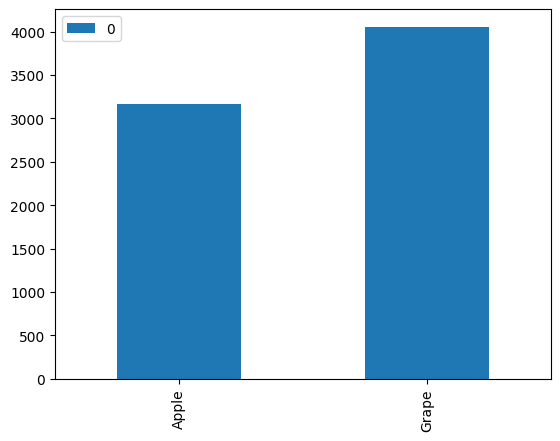

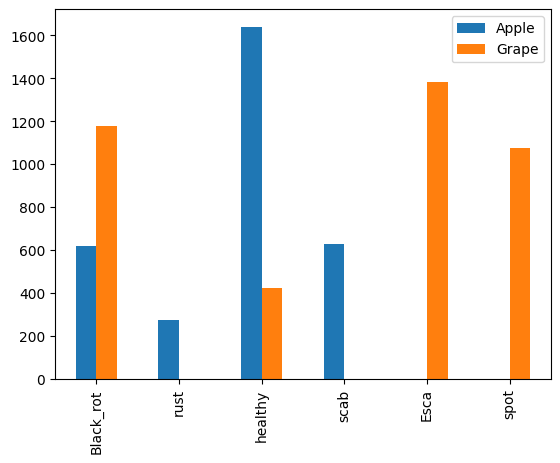

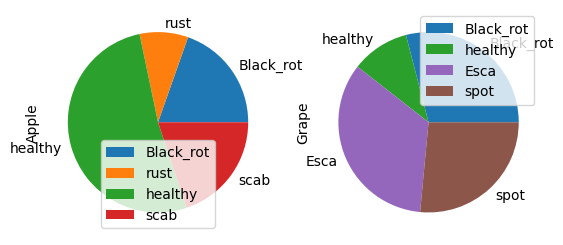

In [4]:
data = get_classes(DATA_FOLDER)
put_distribution(data)

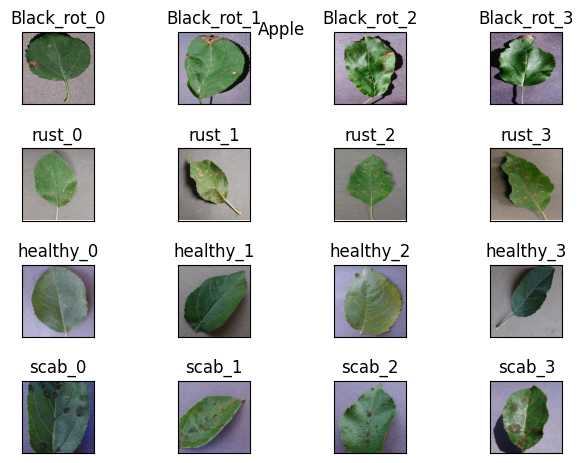

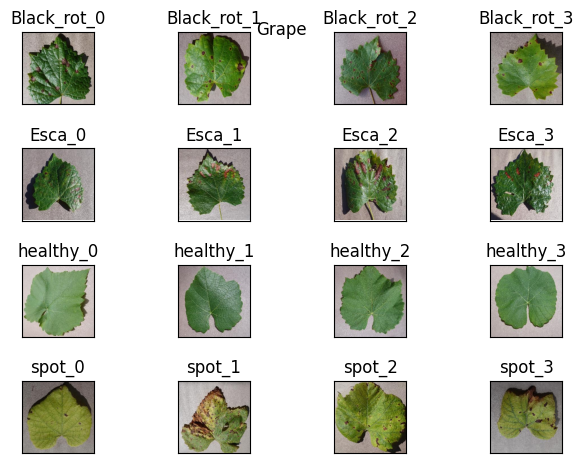

In [5]:
put_pictures(DATA_FOLDER)

# Augmentation

In [6]:
x = random.gauss(mu=0.0, sigma=1.0) #normal
#[0 1[
x = random.randint(0, 360) #[a b]
#[0 1[
x = random.random() #[0 1[
print(x)


0.9308136119941005


In [7]:
def rot_im(im: any, r = None) -> any:
    if r is None:
        r = random.randint(-45, 45)
    return im.rotate(r)

def blur_im(im: any, r = None) -> any:
    max_blur = 3
    if r is None:
        r = random.randint(0, 2 * max_blur)
    if r < max_blur:
        return im.filter(PIL.ImageFilter.BoxBlur(1 + r % max_blur))
    return im.filter(PIL.ImageFilter.GaussianBlur(1 + r % max_blur))

def contrast_im(img, r = None):
    if r is None:
        r = random.randint(-128 // 2, 128 // 2)
    factor = (259 * (r + 255)) / (255 * (259 - r))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return value
    return img.point(contrast)

def zoom_im(img):
    w, h = img.size
    x = random.randint(3 * w // 8, 5 * w // 8)
    y = random.randint(3 * h // 8, 4 * h // 8)
    zoom = random.gauss(mu=1.0, sigma=0.2) * 2
    mod = img.crop((x - w / zoom, y - h / zoom, 
                    x + w / zoom, y + h / zoom))
    return mod.resize((w, h), PIL.Image.LANCZOS)

def brighten_im(img, r = None):
    if r is None:
        r = random.gauss(mu=1.0, sigma=0.3)
    mod = PIL.ImageEnhance.Brightness(img)
    return mod.enhance(r)

def perspective_im(img):
    def find_coeffs(pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
    
        A = np.matrix(matrix, dtype=float)
        B = np.array(pb).reshape(8)
    
        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)
    width, height = img.size
    r_max = min(width, height) // 10
    def rand_coef(l: list[int]) -> list[int]:
        pb = []
        for pt in l:
            pb.append(tuple([e + random.randint(-r_max, r_max) for e in list(pt)]))
        return pb
    pa = [(0, 0), (width, 0), (width, height), (0, height)]
    pb = rand_coef(pa)
    coeffs = find_coeffs(pa, pb)
    return img.transform((width, height), 
                        PIL.Image.PERSPECTIVE, 
                        coeffs,
                        PIL.Image.BICUBIC)

def transform_file(path: str) -> None:
    img = PIL.Image.open(file)
    tf = {'default': lambda x: x,
          'rot': rot_im,
          'blur': blur_im,
          'contrast': contrast_im,
          'zoom': zoom_im,
          'brighten': brighten_im,
          'perspective': perspective_im}
    n = 5
    f, axarr = plt.subplots(n, len(tf))
    f.set_figheight(15)
    f.set_figwidth(15)
    f.tight_layout()
    plt.suptitle(f"Transforms")
    for j in range(5):
        for i, name in enumerate(tf):
            ax = axarr[j, i]
            mod = tf[name](img)
            ax.imshow(mod)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.title.set_text(f"{name}_{j}")
    plt.show()

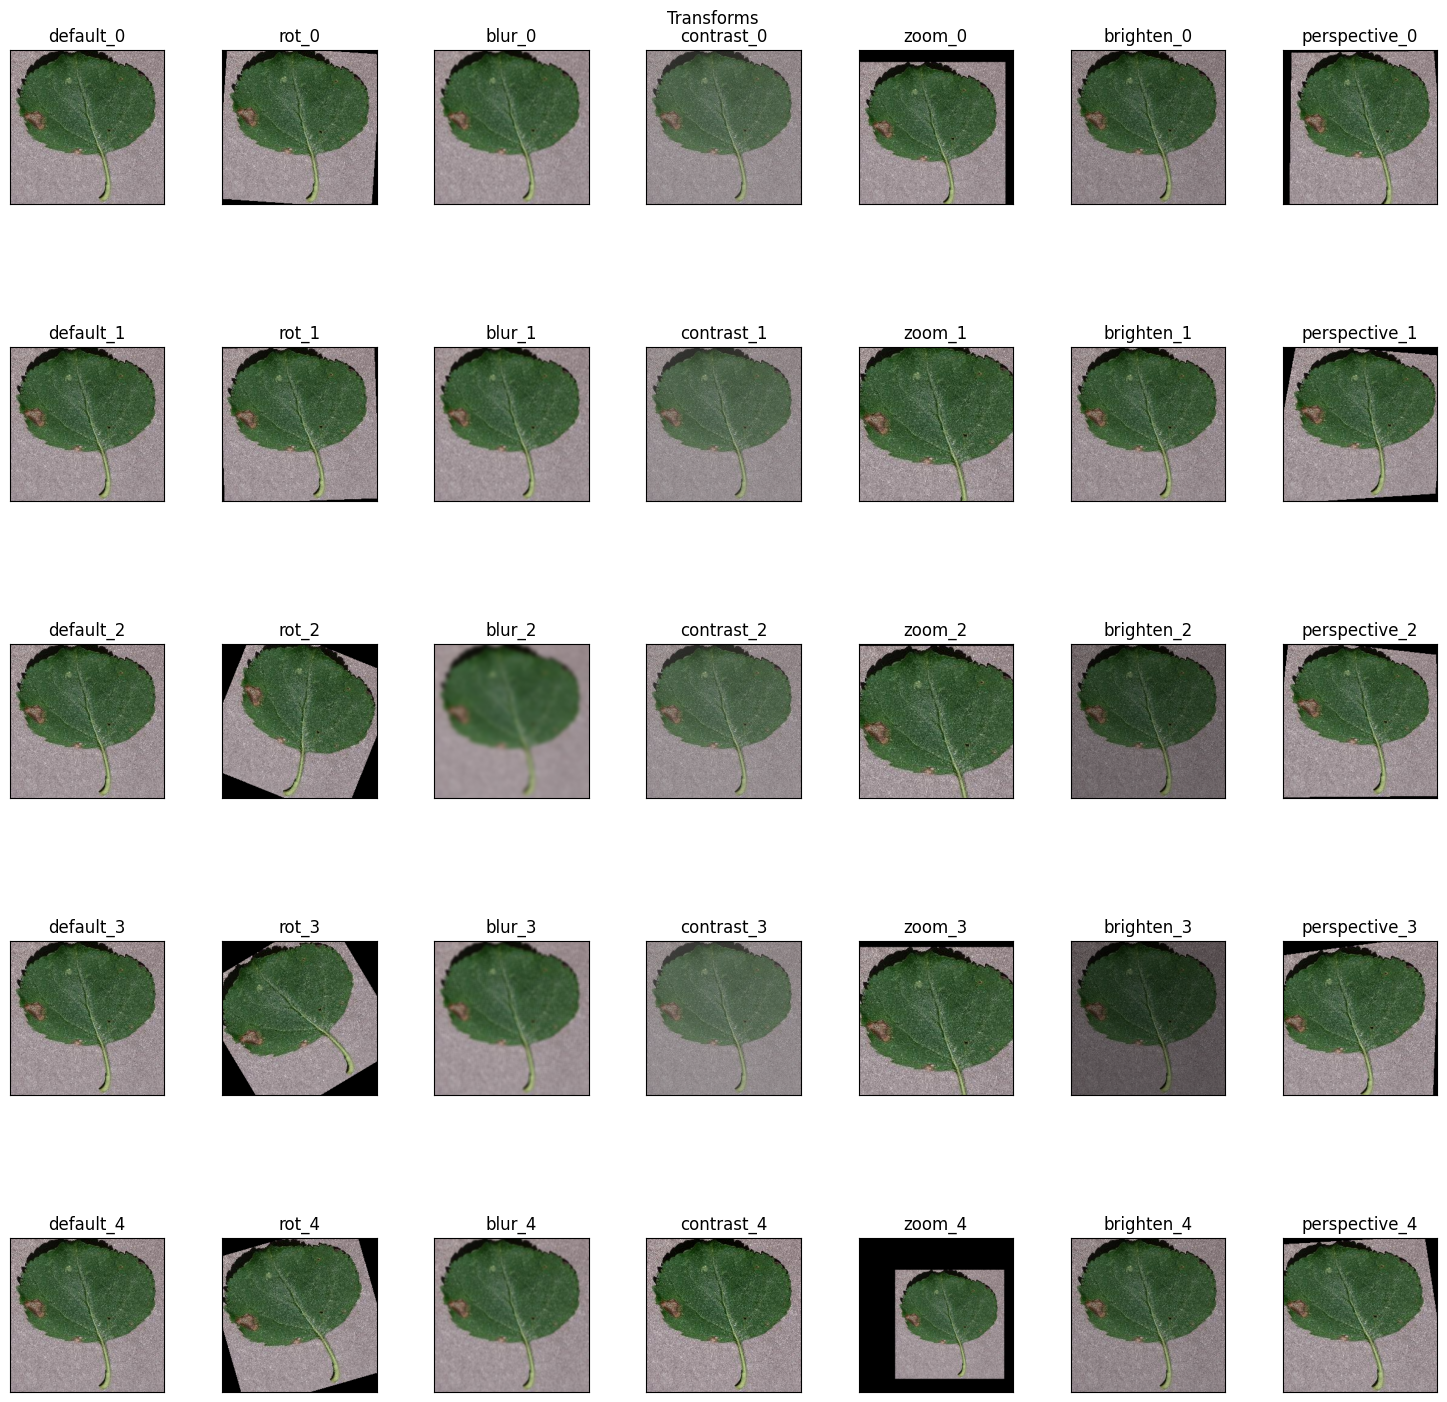

In [8]:
files = get_classes(DATA_FOLDER, lambda x, y, z : f"{x}/{z[0]}")
file = next(iter(next(iter(files.values())).values()))

transform_file(file)

# Transformation

In [9]:
files = get_classes(DATA_FOLDER, lambda x, y, z : f"{x}/{z[0]}")
file = next(iter(next(iter(files.values())).values()))
img, _, _ = pcv.readimage(file, mode="native")

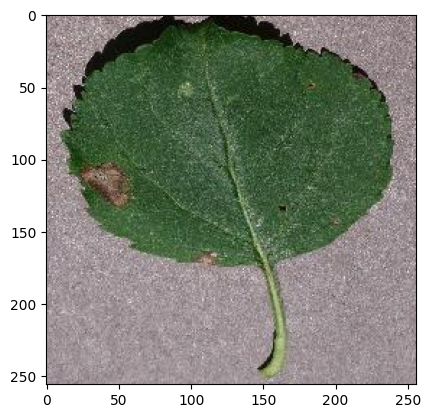

In [10]:
pcv.plot_image(img)


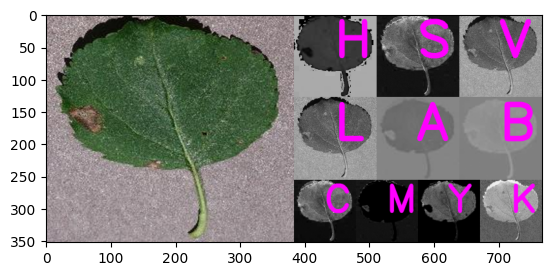

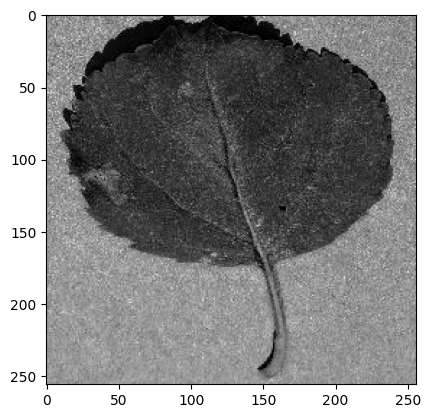

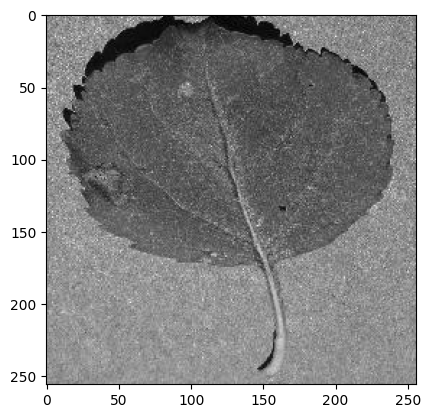

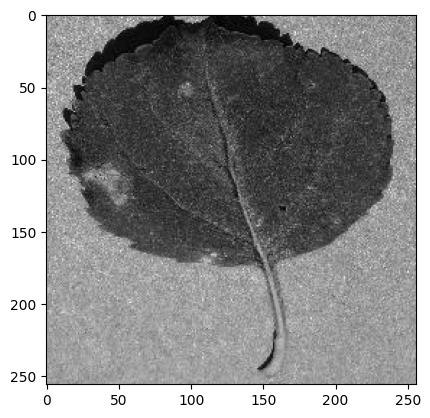

In [11]:
pcv.params.text_size=5
pcv.params.text_thickness=15
colorspace_img = pcv.visualize.colorspaces(rgb_img=img)
pcv.plot_image(colorspace_img)
img_r = img.copy()
img_r[:, :, 1] = img[:, :, 0]
img_r[:, :, 2] = img[:, :, 0]
pcv.plot_image(img_r)
img_g = img.copy()
img_g[:, :, 0] = img[:, :, 1]
img_g[:, :, 2] = img[:, :, 1]
pcv.plot_image(img_g)
img_b = img.copy()
img_b[:, :, 0] = img[:, :, 2]
img_b[:, :, 1] = img[:, :, 2]
pcv.plot_image(img_b)

In [12]:
def visualize_dual_channels(x_channel, y_channel, points, file=file):
    f, ax = pcv.visualize.pixel_scatter_plot(paths_to_imgs=[file] , x_channel=x_channel, y_channel=y_channel)
    x0, y0 = points[0]
    x1, y1 = points[1]
    ax.plot([x0, x1], [y0, y1])
    plt.show()

def mask_dual_channels(x_channel, y_channel, points, **kwargs):
    if 'above' in kwargs:
        above = kwargs['above']
    else:
        above = True
    if 'rgb_img' in kwargs:
        rgb_img = kwargs['rgb_img']
    else:
        rgb_img = img #global
    if 'fill_holes' in kwargs:
        fill_holes = kwargs['fill_holes']
    else:
        fill_holes = True #global
    if 'plot' in kwargs:
        plot = kwargs['plot']
    else:
        plot = True #global
    thresh = pcv.threshold.dual_channels(rgb_img = rgb_img, x_channel = x_channel, y_channel = y_channel, points = points, above=above)
    mask = pcv.fill(bin_img=thresh, size=50)
    if fill_holes is True:
        mask = pcv.fill_holes(mask)
    if plot is True:
        masked = pcv.apply_mask(rgb_img, mask, 'white')
        pcv.plot_image(rgb_img)
        pcv.plot_image(thresh)
        pcv.plot_image(mask)
        pcv.plot_image(masked)
    return mask


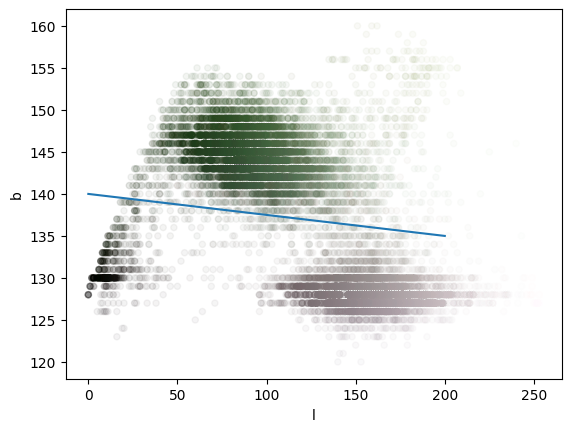

In [13]:
points = [(0,140),(200,135)]
visualize_dual_channels('l', 'b', points)

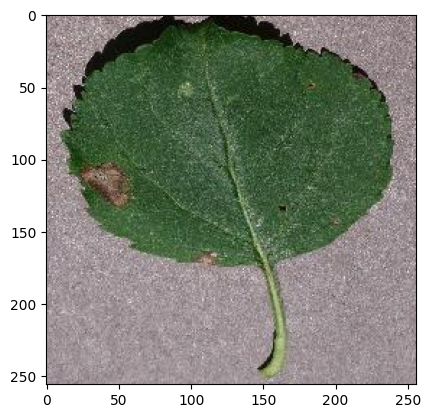

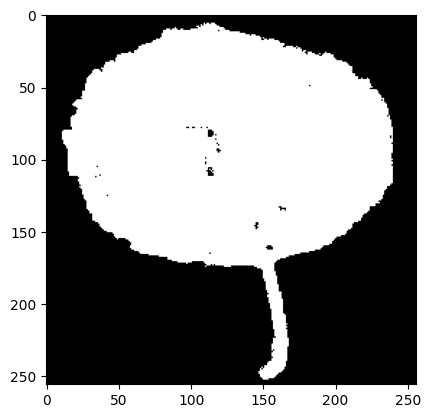

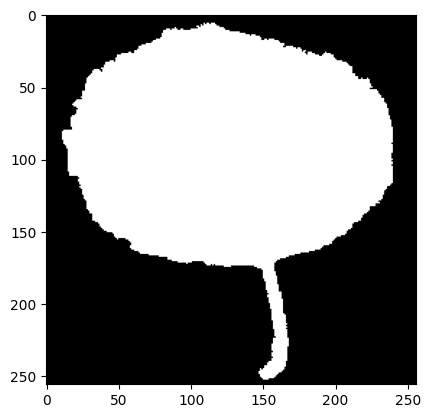

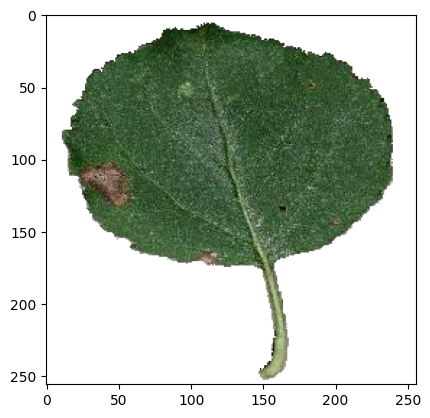

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(256, 256), dtype=uint8)

In [14]:
points = [(0,140),(200,135)]
mask_dual_channels('l', 'b', points)

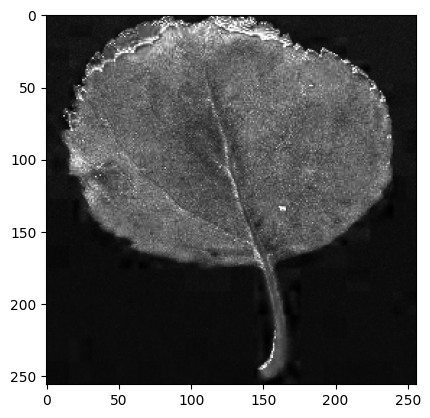

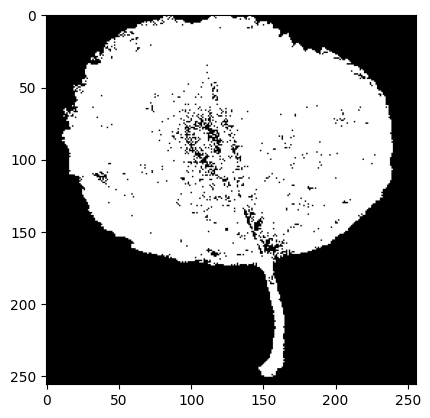

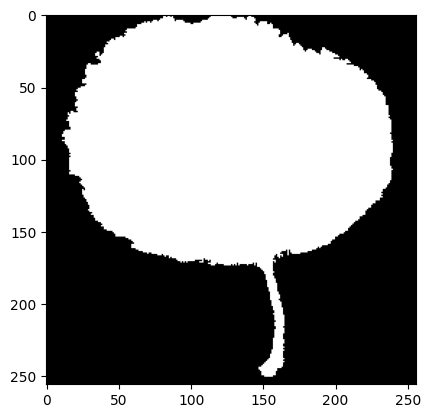

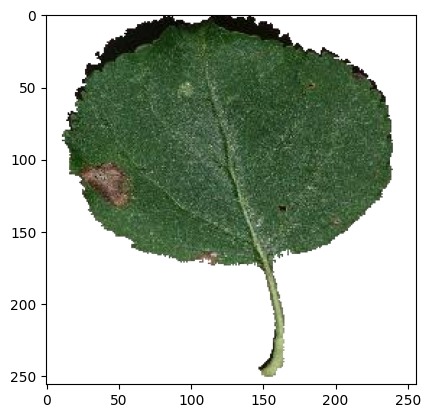

In [15]:
gray_img = pcv.rgb2gray_cmyk(rgb_img=img, channel='c')
thresh = pcv.threshold.otsu(gray_img, object_type="light")
mask = pcv.fill(bin_img=thresh, size=100)
mask = pcv.fill_holes(mask)
masked = pcv.apply_mask(img, mask, 'white')

pcv.plot_image(gray_img)
pcv.plot_image(thresh)
pcv.plot_image(mask)
pcv.plot_image(masked)

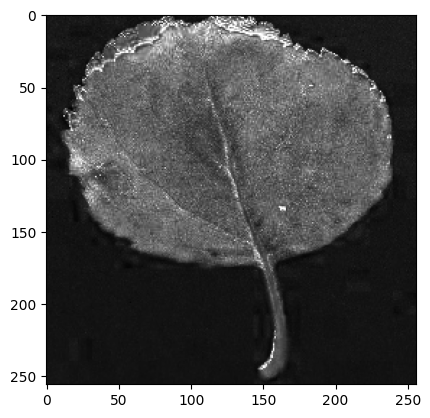

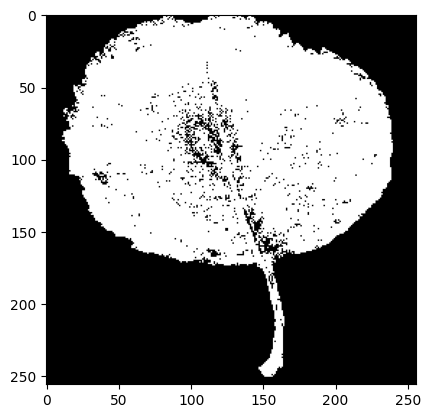

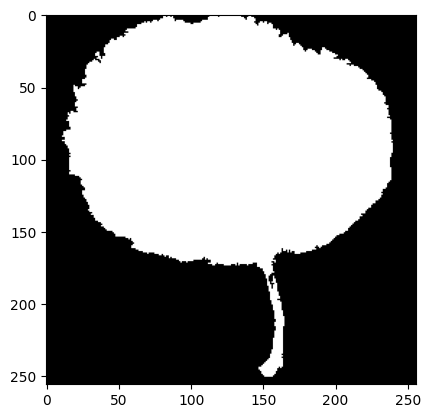

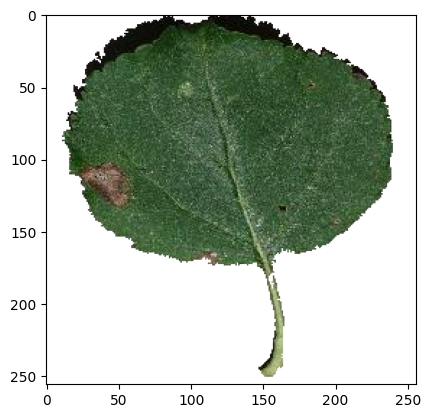

In [16]:
gray_img = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
# gray_img, _, _ = pcv.readimage(file, mode="gray")
thresh = pcv.threshold.otsu(gray_img, object_type="light")
mask = pcv.fill(bin_img=thresh, size=100)
mask = pcv.fill_holes(mask)
masked = pcv.apply_mask(img, mask, 'white')

pcv.plot_image(gray_img)
pcv.plot_image(thresh)
pcv.plot_image(mask)
pcv.plot_image(masked)

In [33]:
# model_path = "./kmeansout_.fit"

# pcv.learn.train_kmeans(img_dir="./images/Apple_healthy", 
#              out_path=model_path, k=6, patch_size=4, num_imgs=10)

# #Labeling a target image
# labeled_img = pcv.predict_kmeans(img=file,
#                                  model_path=model_path, patch_size=5)

# #Choosing clusters for each category within the seed image
# background = pcv.mask_kmeans(labeled_img=labeled_img, k=10, cat_list=[0, 2, 4, 6, 7])
# sick = pcv.mask_kmeans(labeled_img=labeled_img, k=10, cat_list=[1, 3])
# leaf = pcv.mask_kmeans(labeled_img=labeled_img, k=10, cat_list=[5, 8, 9])


AttributeError: module 'plantcv.plantcv' has no attribute 'learn'

In [31]:
print(file)

./images/Apple_Black_rot/image (1).JPG


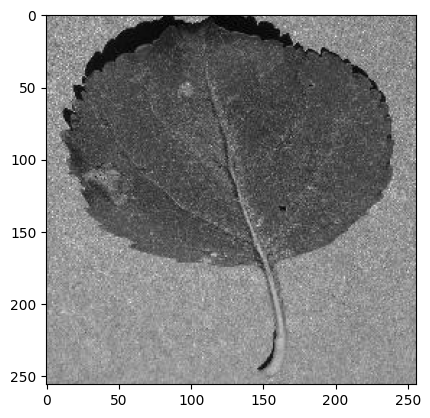

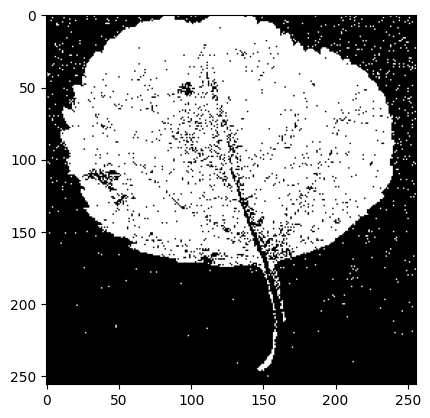

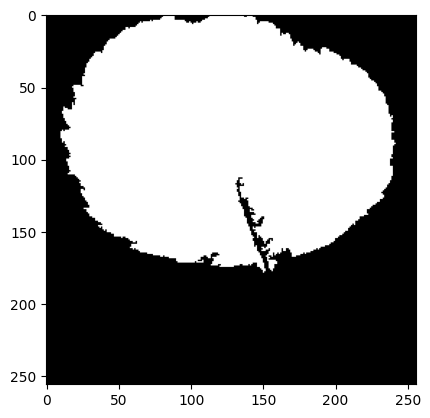

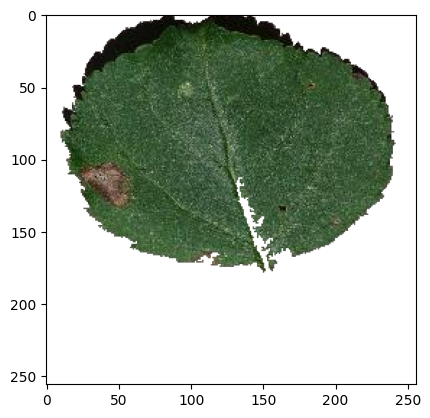

In [17]:
gray_img, _, _ = pcv.readimage(file, mode="gray")
thresh = pcv.threshold.triangle(gray_img, object_type="dark", xstep=1)
mask = pcv.fill(bin_img=thresh, size=100)
mask = pcv.fill_holes(mask)
masked = pcv.apply_mask(img, mask, 'white')

pcv.plot_image(gray_img)
pcv.plot_image(thresh)
pcv.plot_image(mask)
pcv.plot_image(masked)

In [18]:
# gray_img, _, _ = pcv.readimage(file, mode="gray")
# thresh = pcv.threshold.texture(gray_img, ksize=6, threshold=7, offset=3, 
#                                     texture_method='dissimilarity', borders='nearest')
# mask = pcv.fill(bin_img=thresh, size=50)
# mask = pcv.fill_holes(mask)
# masked = pcv.apply_mask(img, mask, 'white')

# pcv.plot_image(gray_img)
# pcv.plot_image(thresh)
# pcv.plot_image(mask)
# pcv.plot_image(masked)

In [27]:
def observe_leaf(img, title='', file=file, debug=False, method='dual'):
    if 'otsu-s' == method:
        gray_img = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
        bin_img = pcv.threshold.otsu(gray_img, object_type="light")
        bin_img = pcv.fill(bin_img=bin_img, size=100)
        bin_img = pcv.fill_holes(bin_img)
    elif 'otsu-c' == method:
        gray_img = pcv.rgb2gray_cmyk(rgb_img=img, channel='c')
        bin_img = pcv.threshold.otsu(gray_img, object_type="light")
        bin_img = pcv.fill(bin_img=bin_img, size=100)
        bin_img = pcv.fill_holes(bin_img)
    # elif 'triangle' == method:
    #     gray_img = pcv.rgb2gray(img)
    #     bin_img = pcv.threshold.triangle(gray_img, object_type="dark")
    #     bin_img = pcv.fill(bin_img=bin_img, size=100)
    #     bin_img = pcv.fill_holes(bin_img)
    else:
        points = [(0,140),(200,135)]
        x_channel = 'l'
        y_channel = 'b'
        if debug is True:
            visualize_dual_channels(x_channel, y_channel, points, file=file)
        bin_img = mask_dual_channels(x_channel, y_channel, points, plot=debug, rgb_img=img)
    pcv.plot_image(img)
    pcv.plot_image(bin_img)
    roi = pcv.roi.from_binary_image(img=img, bin_img=bin_img)
    kept_mask  = pcv.roi.filter(mask=bin_img, roi=roi, roi_type='partial')
    analysis_image = pcv.analyze.size(img=img, labeled_mask=kept_mask)
    color_histogram = pcv.analyze.color(rgb_img=img, labeled_mask=kept_mask, colorspaces='all', label='test')
    observations = pcv.outputs.observations['test_1']
    colors = {'blue': 'b',
              'red': 'r',
              'green': 'g',
              'lightness': 'k',
              'green-magenta': 'm',
              'blue-yellow': 'y'}
    
    def scale_to_x(l, x = 100):
        _l = np.array(l)
        return (_l - _l[0]) * x / (_l[-1] - _l[0])

    pcv.plot_image(analysis_image)
    for key in observations.keys():
        if key.endswith('_frequencies'):
            _label = key[:(-len('_frequencies'))]
            _d = observations[key]
            intensity = _d['label']
            intensity = scale_to_x(intensity, x=100)
            if _label in colors:
                plt.plot(intensity, _d['value'], label=_label, color=colors[_label])
            else:
                plt.plot(intensity, _d['value'], label=_label)
    plt.xlabel('intensity (%)')
    plt.ylabel('proportion (%)')
    plt.legend()
    plt.title(title)
    plt.show()


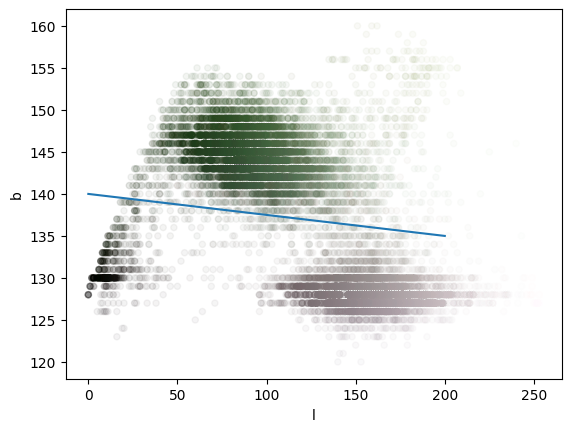

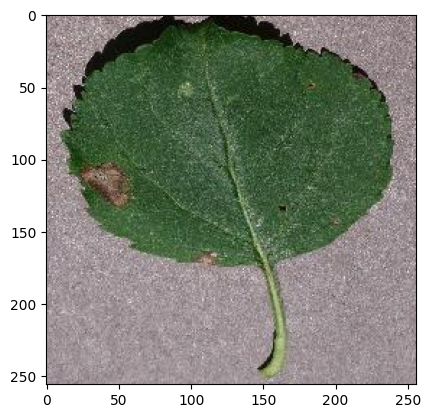

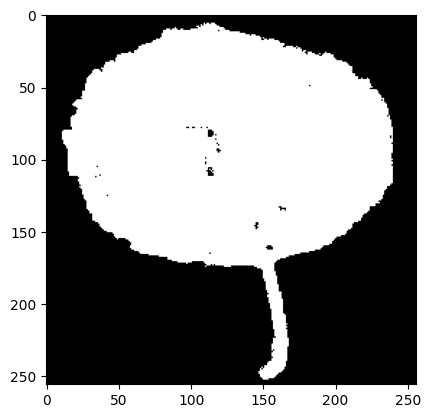

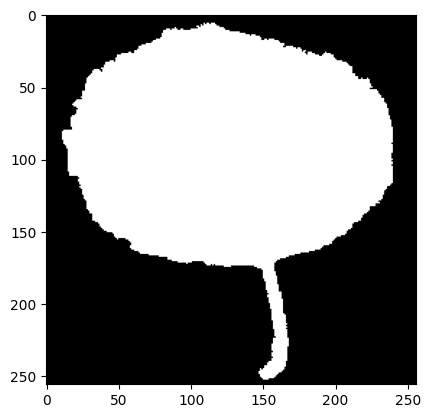

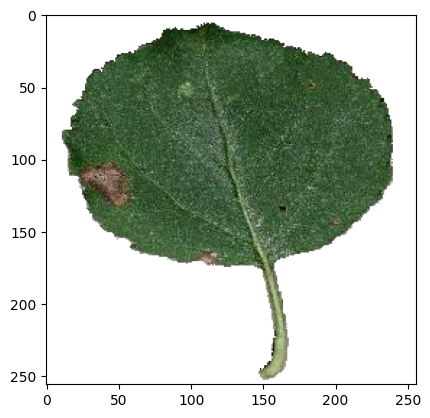

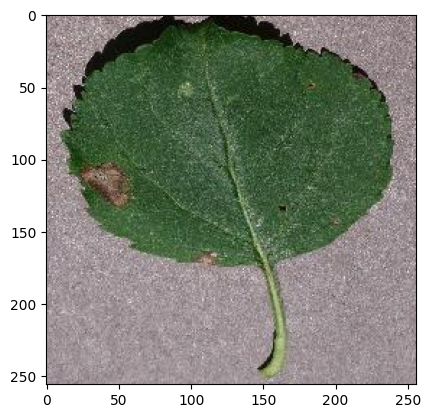

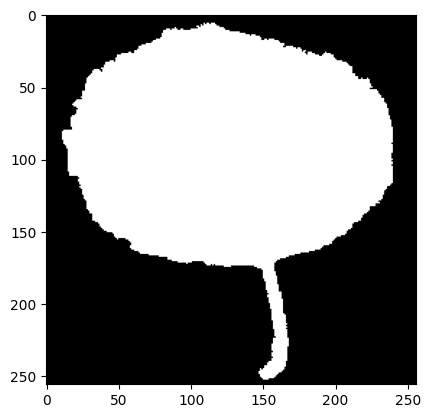

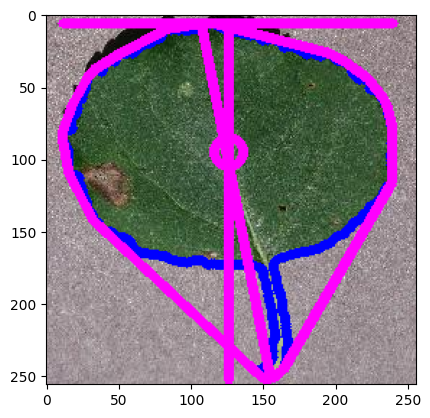

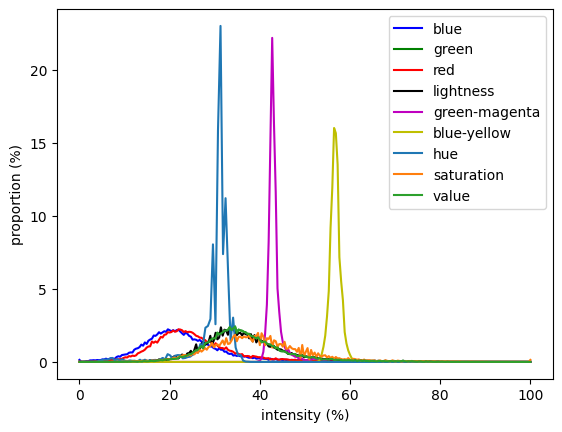

In [25]:
observe_leaf(img, debug=True, file=file)

In [1]:
# _files = get_classes(DATA_FOLDER, lambda x, y, z : [f"{x}/{z[i]}" for i in range(4)])
# for _leaf in _files:
#     for _affliction in _files[_leaf]:
#         _l = _files[_leaf][_affliction]
#         for _f in _l[:4]:
#             _img, _, _ = pcv.readimage(_f, mode="native")
#             #observe_leaf(_img, f"otsu-s {_leaf}_{_affliction}", file=_f, method='otsu-s')
#             #observe_leaf(_img, f"otsu-c {_leaf}_{_affliction}", file=_f, method='otsu-c')
#             observe_leaf(_img, f"dual {_leaf}_{_affliction}", debug=True, file=_f)